# Bike Rental Prediction
The project will involve the prediction of the total number of bikes people rent in a certain hour. The dataset used in this project is taken directly from the [UCI ML repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). An hourly count of bike rentals is recorded for the Capital bikeshare system from 2011 to 2012 with corresponding calendar and weather data.

## Data Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 500)
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.isnull().sum().sum()

0

In [5]:
bike_rentals.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Our goal will be to predict the bike count column `cnt` using all the other feature columns (other than `casual` and `registered` since these sum up to `cnt`). Other than the `dteday` column, the remaining features are all numerical, so they can be easily used as inputs to regression algorithms.

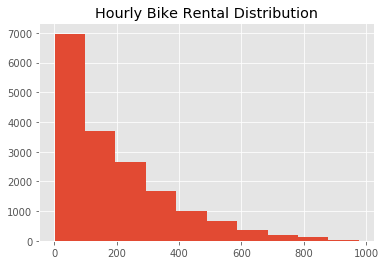

In [6]:
# Histogram of the `cnt` column
import matplotlib.style as style
style.use('ggplot')
counts = bike_rentals['cnt']
plt.hist(counts)
plt.title('Hourly Bike Rental Distribution')
plt.show()

A histogram of bike rentals on an hourly basis indicates that on most hours, less than 200 bikes are rented. The rental frequency distribution decays exponentially as more bikes are rented within an hour, which makes sense intuitively for a business.

In [7]:
# Correlation of features to the 'cnt' target column
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Generating correlation coefficients to the target variable helps identify which features have a strong linear relationship to the target `cnt` column.

## Feature Engineering
Generating new feature can improve the prediction performance of machine learning models in certain cases. An area for improvement would be the `hr` feature where each hour of the day would be considered different by a prediction model. In order to help our models learn, we can reduce the granularity of this feature by only considering four different times in a day corresponding to morning, afternoon, evening, and night.

In [8]:
# Function to assign a time of day corresponidng to an hour
def assign_label(hr):
    if hr>=6 and hr<12:
        return 1 #morning
    elif hr>=12 and hr<18:
        return 2 #afternoon
    elif hr>=18 and hr<24:
        return 3 #evening
    elif hr>=0 and hr<6:
        return 4 #night
    
# apply function to dataframe
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

We can also construct a feature indicating when the feeling temperature `atemp` is comfortable. A comfortable temperature will be denoted as in the range of 13 degrees to 29 degrees Celcius.

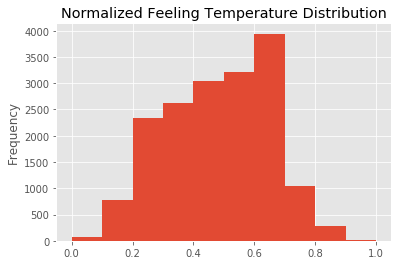

In [9]:
bike_rentals['atemp'].plot.hist()
plt.title('Normalized Feeling Temperature Distribution')
plt.show()

In [10]:
tComfort_min = 13
tComfort_max = 29

# normalized with (t-t_min)/(t_max-t_min) from dataset documentation
t_min = -16
t_max = 50

# Normalize comfort range
tComfort_min_norm = (tComfort_min-t_min)/(t_max-t_min)
tComfort_max_norm = (tComfort_max-t_min)/(t_max-t_min)

bike_rentals['comfort_temp'] = (bike_rentals['atemp'] >= tComfort_min_norm) & (bike_rentals['atemp'] <= tComfort_max_norm)
bike_rentals['comfort_temp'] = bike_rentals['comfort_temp'].astype('int')
bike_rentals['comfort_temp'].value_counts()

0    8779
1    8600
Name: comfort_temp, dtype: int64

It may be possible that people have more time on weekends, thus increasing the number of potential bike rentals. Because of this, we can encode a new binary `weekend` feature which indicates if the day falls on a weekend or not.

In [11]:
## Indicate if weekday is Saturday (0) or Sunday (6)
bike_rentals['weekend'] = (bike_rentals['weekday'] == 0) | (bike_rentals['weekday'] == 6)
bike_rentals['weekend'] = bike_rentals['weekend'].astype('int')
bike_rentals['weekend'].value_counts()

0    12365
1     5014
Name: weekend, dtype: int64

In [12]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label,comfort_temp,weekend
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4,0,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4,0,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4,0,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4,0,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4,0,1


## Train & Test Split
Before training our models, we will split the dataset into a training set and a testing set. By training only on the train set, and evaluating the performance of our algorithm on both splits, we can identify how the algorithm performs on unseen data, and if the algorithm is overfitting.

In [13]:
# 80% train, 20% test
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

As mentioned previously, lets drop `casual`, `registered`, and `dteday` feature columns. At first we considered only features with a correlation coefficient greater than 0.03 to avoid injecting noise into our model. Further testing of different models made it clear that the features have a non-linear relationship with the target variable since tree-based models drastically outperformed linear regression models based on RMSE. Based on this reasoning, all features were kept by setting the cutoff to 0.

In [14]:
feature_corr = bike_rentals.corr()['cnt'].abs().sort_values(ascending=False)
feature_corr = feature_corr.drop(['cnt', 'casual','registered'])
feature_corr 

temp            0.404772
atemp           0.400929
hr              0.394071
time_label      0.378318
hum             0.322911
instant         0.278379
yr              0.250495
comfort_temp    0.179455
season          0.178056
weathersit      0.142426
mnth            0.120638
windspeed       0.093234
holiday         0.030927
workingday      0.030284
weekday         0.026900
weekend         0.019699
Name: cnt, dtype: float64

In [15]:
## Set the correlation cutoff for features
#corr_cutoff = 0.03
corr_cutoff = 0 #Better models
feature_corr = feature_corr[feature_corr > corr_cutoff]

In [16]:
# Filter kept features
kept_features = feature_corr.index

X_train = train[kept_features]
X_test = test[kept_features]
y_train = train['cnt']
y_test = test['cnt']

We will be using a root mean squared error (RMSE) to evaluate the prediction performance of our regression algorithms since it works well on continuous numeric target data. It also provides some interpretability (on the same scale) as to how much error the model's predictions usually have with regards to number of bikes.

## Baseline Model Selection
In order to select a baseline regression model, we will test the prediction performance of the following supervised learning algorithms:
- Linear Regression
- Decision Tree
- Random Forest
- Gradient Boosted Trees

### Linear Regression

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on Train/Test
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

# Train/Test error
train_err_lr = mean_squared_error(y_train, train_pred) ** 0.5
test_err_lr = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE:', round(train_err_lr,2))
print('Test RMSE:', round(test_err_lr,2))

Train RMSE: 132.39
Test RMSE: 130.13


### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(min_samples_leaf=10)
dt.fit(X_train, y_train)

# Predict on Train/Test
train_pred = dt.predict(X_train)
test_pred = dt.predict(X_test)

# Train/Test error
train_err_dt = mean_squared_error(y_train, train_pred) ** 0.5
test_err_dt = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE:', round(train_err_dt,2))
print('Test RMSE:', round(test_err_dt,2))

Train RMSE: 40.14
Test RMSE: 51.44


The decision tree is significantly more accurate than the linear regression model. To improve upon this, we can try ensembled tree models to see if we can reduce our errors further via bagging or boosting.

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features='auto', random_state=1)
rf.fit(X_train, y_train)

# Predict on Train/Test
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

# Train/Test error
train_err_rf = mean_squared_error(y_train, train_pred) ** 0.5
test_err_rf = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE:', round(train_err_rf,2))
print('Test RMSE:', round(test_err_rf,2))

Train RMSE: 15.16
Test RMSE: 42.85


Based on the results presented, the random forest model seems to perform the best on both seen and unseen data. None of the models are seen to significantly overfit the training data based on their relative train and test RMSEs. 

The random forest model likely performs the best due to being able to capture non-linear relationships within the variables, unlike a linear regression model. Also, it is an ensembled tree model, so it is capable of negating the effects of overfitting a single decision tree model would be susceptible to.

### Gradient Boosted Trees

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbt = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=8, min_samples_leaf=4, random_state=1)
gbt.fit(X_train, y_train)

# Predict on Train/Test
train_pred = gbt.predict(X_train)
test_pred = gbt.predict(X_test)

# Train/Test error
train_err_gbt = mean_squared_error(y_train, train_pred) ** 0.5
test_err_gbt = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE:', round(train_err_gbt,2))
print('Test RMSE:', round(test_err_gbt,2))

Train RMSE: 22.39
Test RMSE: 39.39


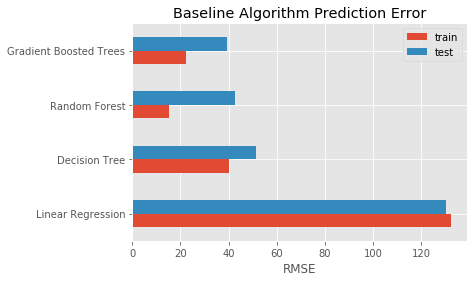

In [21]:
## Visulalize test results
train_rmses = [train_err_lr, train_err_dt, train_err_rf, train_err_gbt]
test_rmses = [test_err_lr, test_err_dt, test_err_rf, test_err_gbt]
index = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']
df_rmse = pd.DataFrame({'train': train_rmses,
                   'test': test_rmses}, index=index)
ax = df_rmse.plot.barh(title='Baseline Algorithm Prediction Error')
ax.set_xlabel('RMSE')
plt.show()

The gradient boosted trees (GBT) model seems to perform the best on both seen and unseen data. None of the models are seen to significantly overfit the training data based on their relative train and test RMSEs. 

GBT likely performs the best due to being able to capture non-linear relationships within the variables, unlike a linear regression model. Also, it is an ensembled tree model, so it is capable of negating the effects of overfitting a single fully grown decision tree model would be susceptible to.

## Model Optimization
Based on the above results of the tests, the GBT model will be tuned to see if there exists a better set of hyperparameters which will improve the model's prediction performance.

In [22]:
## Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import time
from joblib import dump, load

parameter_grid = {
    'learning_rate': np.arange(0.05, 0.2, 0.05),
    'max_depth': np.arange(6, 11, 1),
    'min_samples_leaf': np.arange(2, 6, 1),
    'subsample': [0.8, 1]
}

fileToLoadorSave = 'gbt_tuned_cv.joblib'

try:
    gbt_cv = load(fileToLoadorSave) # Load tuned model if already exists in pwd
except FileNotFoundError:
    # Run GridSearch
    gbt_tune = GradientBoostingRegressor(n_estimators=200, random_state=1)
    #gbt_cv = GridSearchCV(gbt_tune, parameter_grid, n_jobs=-1, cv=4)
    gbt_cv = GridSearchCV(gbt_tune, parameter_grid, n_jobs=-1, cv=4, scoring='neg_root_mean_squared_error')

    t0 = time.time()
    gbt_cv.fit(X_train, y_train)
    t1 = time.time()
    totalTime = t1-t0
    print('Time to tune (sec): ', totalTime)
    dump(gbt_cv, fileToLoadorSave) # Save tuned model to file to avoid rerunning grid search

Time to tune (sec):  1024.0003151893616


In [27]:
# Cross Validation results
print('Best-found parameters: ', gbt_cv.best_params_)
print('Mean 4-fold RMSE test score on the best GBT model: ', round(abs(gbt_cv.best_score_),2))
cvResults = pd.DataFrame(gbt_cv.cv_results_).sort_values('mean_test_score', ascending=False)
cvResults.head() # Display the five best found models

Best-found parameters:  {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 2, 'subsample': 0.8}
Mean 4-fold RMSE test score on the best GBT model:  36.16


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
56,5.384931,0.046546,0.035228,0.001639,0.1,8,2,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_sa...",-36.702173,-36.199448,-37.209874,-34.531650,-36.160786,1.006139,1
58,5.433901,0.020582,0.035477,0.000865,0.1,8,3,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_sa...",-36.681000,-36.405793,-37.001852,-34.583405,-36.168012,0.938878,2
60,5.677750,0.029234,0.041225,0.007080,0.1,8,4,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_sa...",-36.880096,-36.086558,-37.214679,-34.594296,-36.193907,1.010335,3
50,4.899481,0.010588,0.029231,0.000433,0.1,7,3,0.8,"{'learning_rate': 0.1, 'max_depth': 7, 'min_sa...",-36.595970,-36.708260,-37.527678,-34.345786,-36.294423,1.181133,4
99,6.693624,0.019779,0.032730,0.004203,0.15,8,3,1,"{'learning_rate': 0.15000000000000002, 'max_de...",-37.042852,-36.543228,-37.330062,-34.320530,-36.309168,1.182157,5


The best found gradient boosted tree model yields a **mean RMSE of 36.16** (std dev = 1.01) on the 4-fold validation splits, meaning that the model generalizes quite well to unseen data. The low standard deviation observed (relative to mean RMSE) is a good indicator that the model is not overfitting.

Now we will use the best-found hyperparameters to train a model using all of our training data. Its prediction error will then be evaluated.

In [28]:
# Use best-found gbt model to fit on all training data
gbt_best = gbt_cv.best_estimator_
gbt_best.fit(X_train, y_train)

# Predict on Train/Test
train_pred = gbt_best.predict(X_train)
test_pred = gbt_best.predict(X_test)

# Train/Test error (RMSE)
train_err_gbtBest = mean_squared_error(y_train, train_pred) ** 0.5
test_err_gbtBest = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE:', round(train_err_gbtBest,2))
print('Test RMSE:', round(test_err_gbtBest,2))

Train RMSE: 14.68
Test RMSE: 36.98


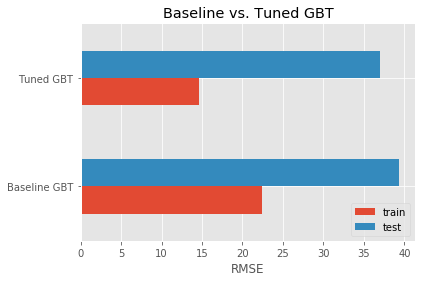

In [29]:
## Visulalize RMSE of GBT models
train_rmses = [train_err_gbt, train_err_gbtBest]
test_rmses = [test_err_gbt, test_err_gbtBest]
index = ['Baseline GBT', 'Tuned GBT']
df_rmse_gbt = pd.DataFrame({'train': train_rmses,
                            'test': test_rmses}, index=index)
ax = df_rmse_gbt.plot.barh(title='Baseline vs. Tuned GBT')
ax.set_xlabel('RMSE')
plt.show()

In [30]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

As a result of hyperparameter optimization, a reduction in both train and test error was achieved. The tuned GBT now has a **test RMSE of 36.98**, which is approximately a 6% decrease in error compared to the baseline GBT model. The test RMSE is also within one standard deviation (1.01) of the 4-fold validation RMSEs, which is another strong indicator that the model is not overfitting to training data and generalizes well to unseen data. Considering that the simplest model which always predicts the mean of all samples' targets has a RMSE of 181.39 (standard deviation), a ~80% overall reduction in RMSE was achieved.

## Conclusion
Using the dataset consisting of Capital's bike rentals over time, a regression model capable of predicting the number of bike rentals at any given hour of the year was developed. The performance of different baseline models were compared against each other, with the best regressor selected and tuned to improve its prediction accuracy.

Major findings were as follows:
- Non-linear, tree-based models drastically outperformed linear models in this dataset.
- Gradient Boosted Trees (GBT) performed the best out of all baseline regression models tested
- The tuned GBT model yielded the lowest RMSE of 36.98 on the testing split (~80% decrease compared to the simplest possible model)